#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sparklines

plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 600

import pyarrow as pa
string_pa = pd.ArrowDtype(pa.string())

import calendar
days_order = calendar.day_abbr[0:]
months_order = calendar.month_abbr[1:]

import time
stime = time.time()

#### Load Dataset

In [2]:
df1 = pd.read_excel('online-retail.xlsx', dtype={'InvoiceNo': 'string', 'StockCode': 'string', 'Description': 'string', 'Country': 'string'})
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df1.shape

(541909, 8)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  string        
 1   StockCode    541909 non-null  string        
 2   Description  540455 non-null  string        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  string        
dtypes: datetime64[ns](1), float64(2), int64(1), string(4)
memory usage: 33.1 MB


#### Data Cleaning: Handle Missing Value

In [5]:
df1.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df1[df1.Description.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,<NA>,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,<NA>,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,<NA>,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,<NA>,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,<NA>,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,<NA>,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom
535326,581203,23406,<NA>,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom
535332,581209,21620,<NA>,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom
536981,581234,72817,<NA>,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom


In [7]:
(df1[df1.StockCode == "22139"]
 .Description
 .mode()
)

0    RETROSPOT TEA SET CERAMIC 11 PC 
Name: Description, dtype: string

In [8]:
most_freq = df1[["StockCode", "Description"]].value_counts().reset_index()

In [9]:
(most_freq[most_freq.StockCode == "85123A"]
 .head(1)
)

,StockCode,Description,count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2302


In [10]:
most_freq = most_freq.groupby("StockCode").head(1)
most_freq.columns = ["StockCode", "freq_Description", "count"]
most_freq

,StockCode,freq_Description,count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2302
1,22423,REGENCY CAKESTAND 3 TIER,2200
2,85099B,JUMBO BAG RED RETROSPOT,2159
3,47566,PARTY BUNTING,1727
4,20725,LUNCH BAG RED RETROSPOT,1638
...,...,...,...
4767,35600A,Found by jackie,1
4769,35597B,BLACKCHRISTMAS TREE 30CM,1
4770,35832,WOOLLY HAT SOCK GLOVE ADVENT STRING,1
4777,37330,BIG POLKADOT MUG,1


In [11]:
df2 = (df1
       .merge(most_freq, on="StockCode", how="left")
       .assign(Description=lambda df_: df_.freq_Description)
       .drop(columns=["freq_Description", "count"])
)
df2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [12]:
df2.isnull().sum()

InvoiceNo           0
StockCode           0
Description       112
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [13]:
df2.dropna(subset=["Description"], inplace=True)
df2.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134968
Country             0
dtype: int64

In [14]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Data Cleaning: Handle Strange Number

In [15]:
df2.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541797.000000,541797,541797.000000,406829.000000
mean,9.555919,2011-07-04 14:06:48.671255296,4.612067,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:36:00,1.250000,13953.000000
50%,3.000000,2011-07-20 08:59:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:41:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.103428,NaN,96.769831,1713.600303


In [16]:
df2[df2.Quantity < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [17]:
df2[df2.UnitPrice < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [18]:
df3 = df2[(df2.UnitPrice > 0) & (df2.Quantity > 0)]
df3.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,530104.000000,530104,530104.000000,397884.000000
mean,10.542037,2011-07-04 20:16:05.225087744,3.907625,15294.423453
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,1.000000,2011-03-28 12:22:00,1.250000,13969.000000
50%,3.000000,2011-07-20 12:58:00,2.080000,15159.000000
75%,10.000000,2011-10-19 12:39:00,4.130000,16795.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,155.524124,NaN,35.915681,1713.141560


In [19]:
df3.Quantity.quantile(0.9999)

1439.8763999990188

In [20]:
df3[df3.Quantity > 1500]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4850,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,2010-12-02 16:48:00,0.55,15299.0,United Kingdom
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
25920,538420,17096,ASSORTED LAQUERED INCENSE HOLDERS,1728,2010-12-12 12:03:00,0.17,12875.0,United Kingdom
32671,539101,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,2400,2010-12-16 10:35:00,0.94,16029.0,United Kingdom
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom
52710,540815,21175,GIN + TONIC DIET METAL SIGN,2000,2011-01-11 12:55:00,1.85,15749.0,United Kingdom
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
80742,543057,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2592,2011-02-03 10:50:00,0.21,16333.0,United Kingdom
87631,543669,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,2400,2011-02-11 11:22:00,0.94,16029.0,United Kingdom


#### Feature Engineering: Create New Columns

In [21]:
df4 = df3.copy()
df4["TotalSales"] = df4.Quantity * df4.UnitPrice
df4.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [22]:
df4["MonthNo"] = df4["InvoiceDate"].dt.to_period("M").dt.to_timestamp()
df4["Month"] = df4["InvoiceDate"].dt.strftime("%b-%y")
df4 = df4.sort_values("MonthNo")
df4.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,MonthNo,Month
115336,546117,21876,POTTERING MUG,1,2011-03-09 13:56:00,1.25,16771.0,United Kingdom,1.25,2011-03-01,Mar-11
127416,547221,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-03-21 15:06:00,2.10,13262.0,United Kingdom,12.60,2011-03-01,Mar-11
535638,581217,22580,ADVENT CALENDAR GINGHAM SACK,11,2011-12-08 09:20:00,4.13,NaN,United Kingdom,45.43,2011-12-01,Dec-11
535693,581217,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2011-12-08 09:20:00,10.79,NaN,United Kingdom,21.58,2011-12-01,Dec-11
291959,562534,23301,GARDENERS KNEELING PAD KEEP CALM,20,2011-08-05 14:49:00,1.65,14031.0,United Kingdom,33.00,2011-08-01,Aug-11


#### Visualization & EDA

In [23]:
from matplotlib.ticker import FuncFormatter, PercentFormatter
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'
def thousands_formatter(x, pos):
    return f'{x / 1e3:.1f}K'

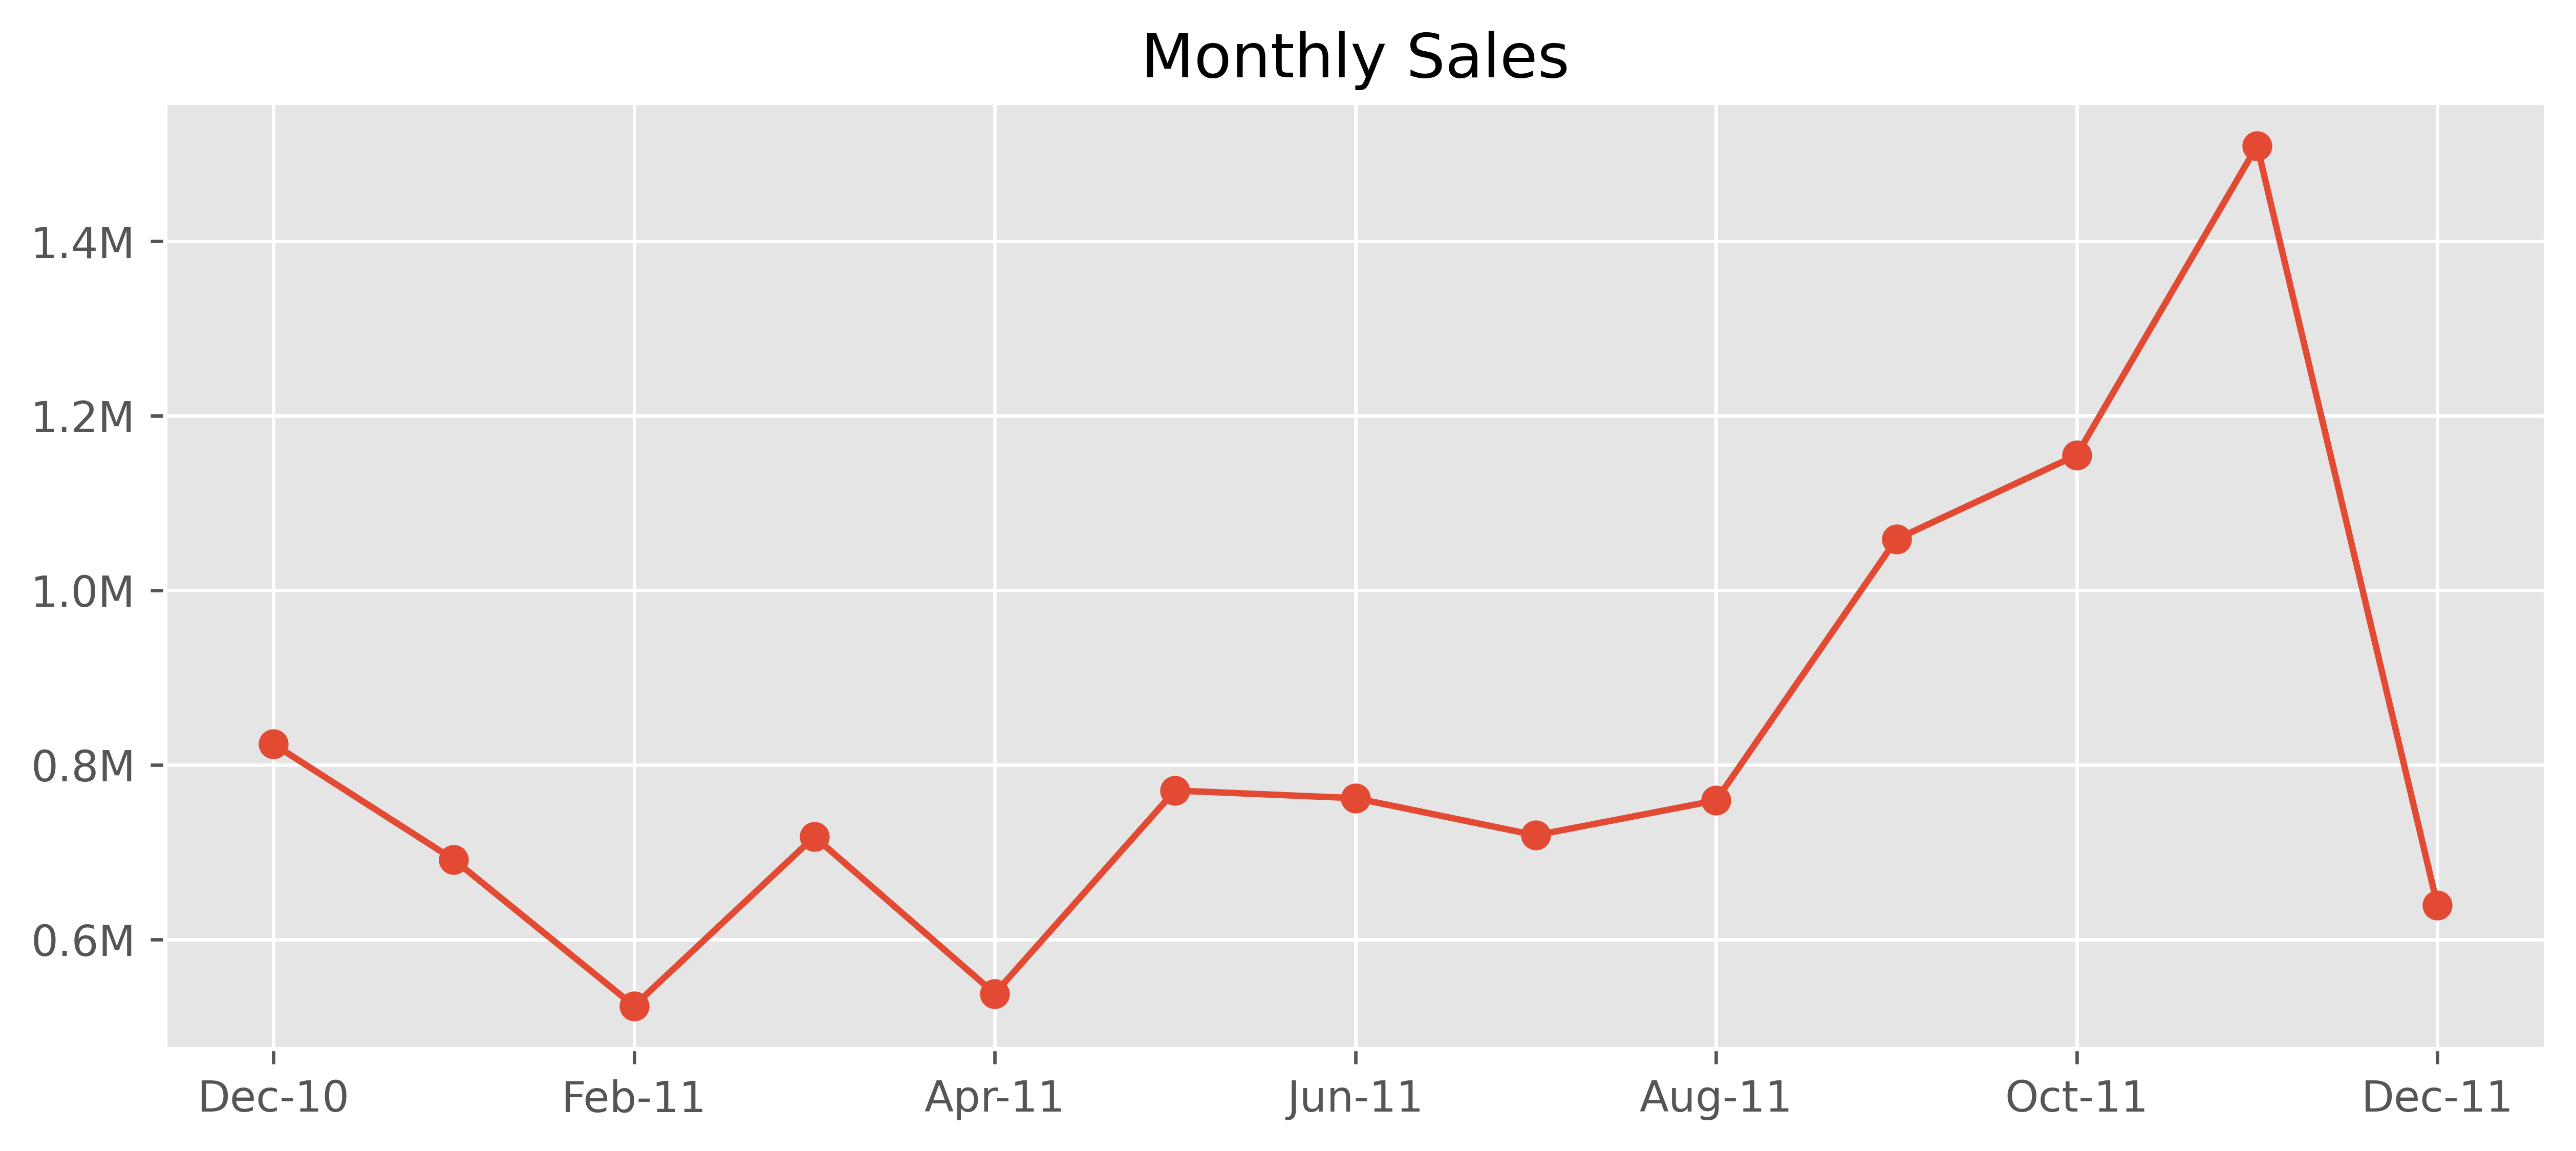

In [24]:
fig, ax = plt.subplots()

(df4.groupby(["MonthNo", "Month"])["TotalSales"]
 .sum()
 .reset_index()
 .sort_values("MonthNo")
 .plot(ax=ax, x="Month", y="TotalSales", kind="line", title="Monthly Sales", marker="o", legend=False)
)

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.xlabel('')
plt.show()

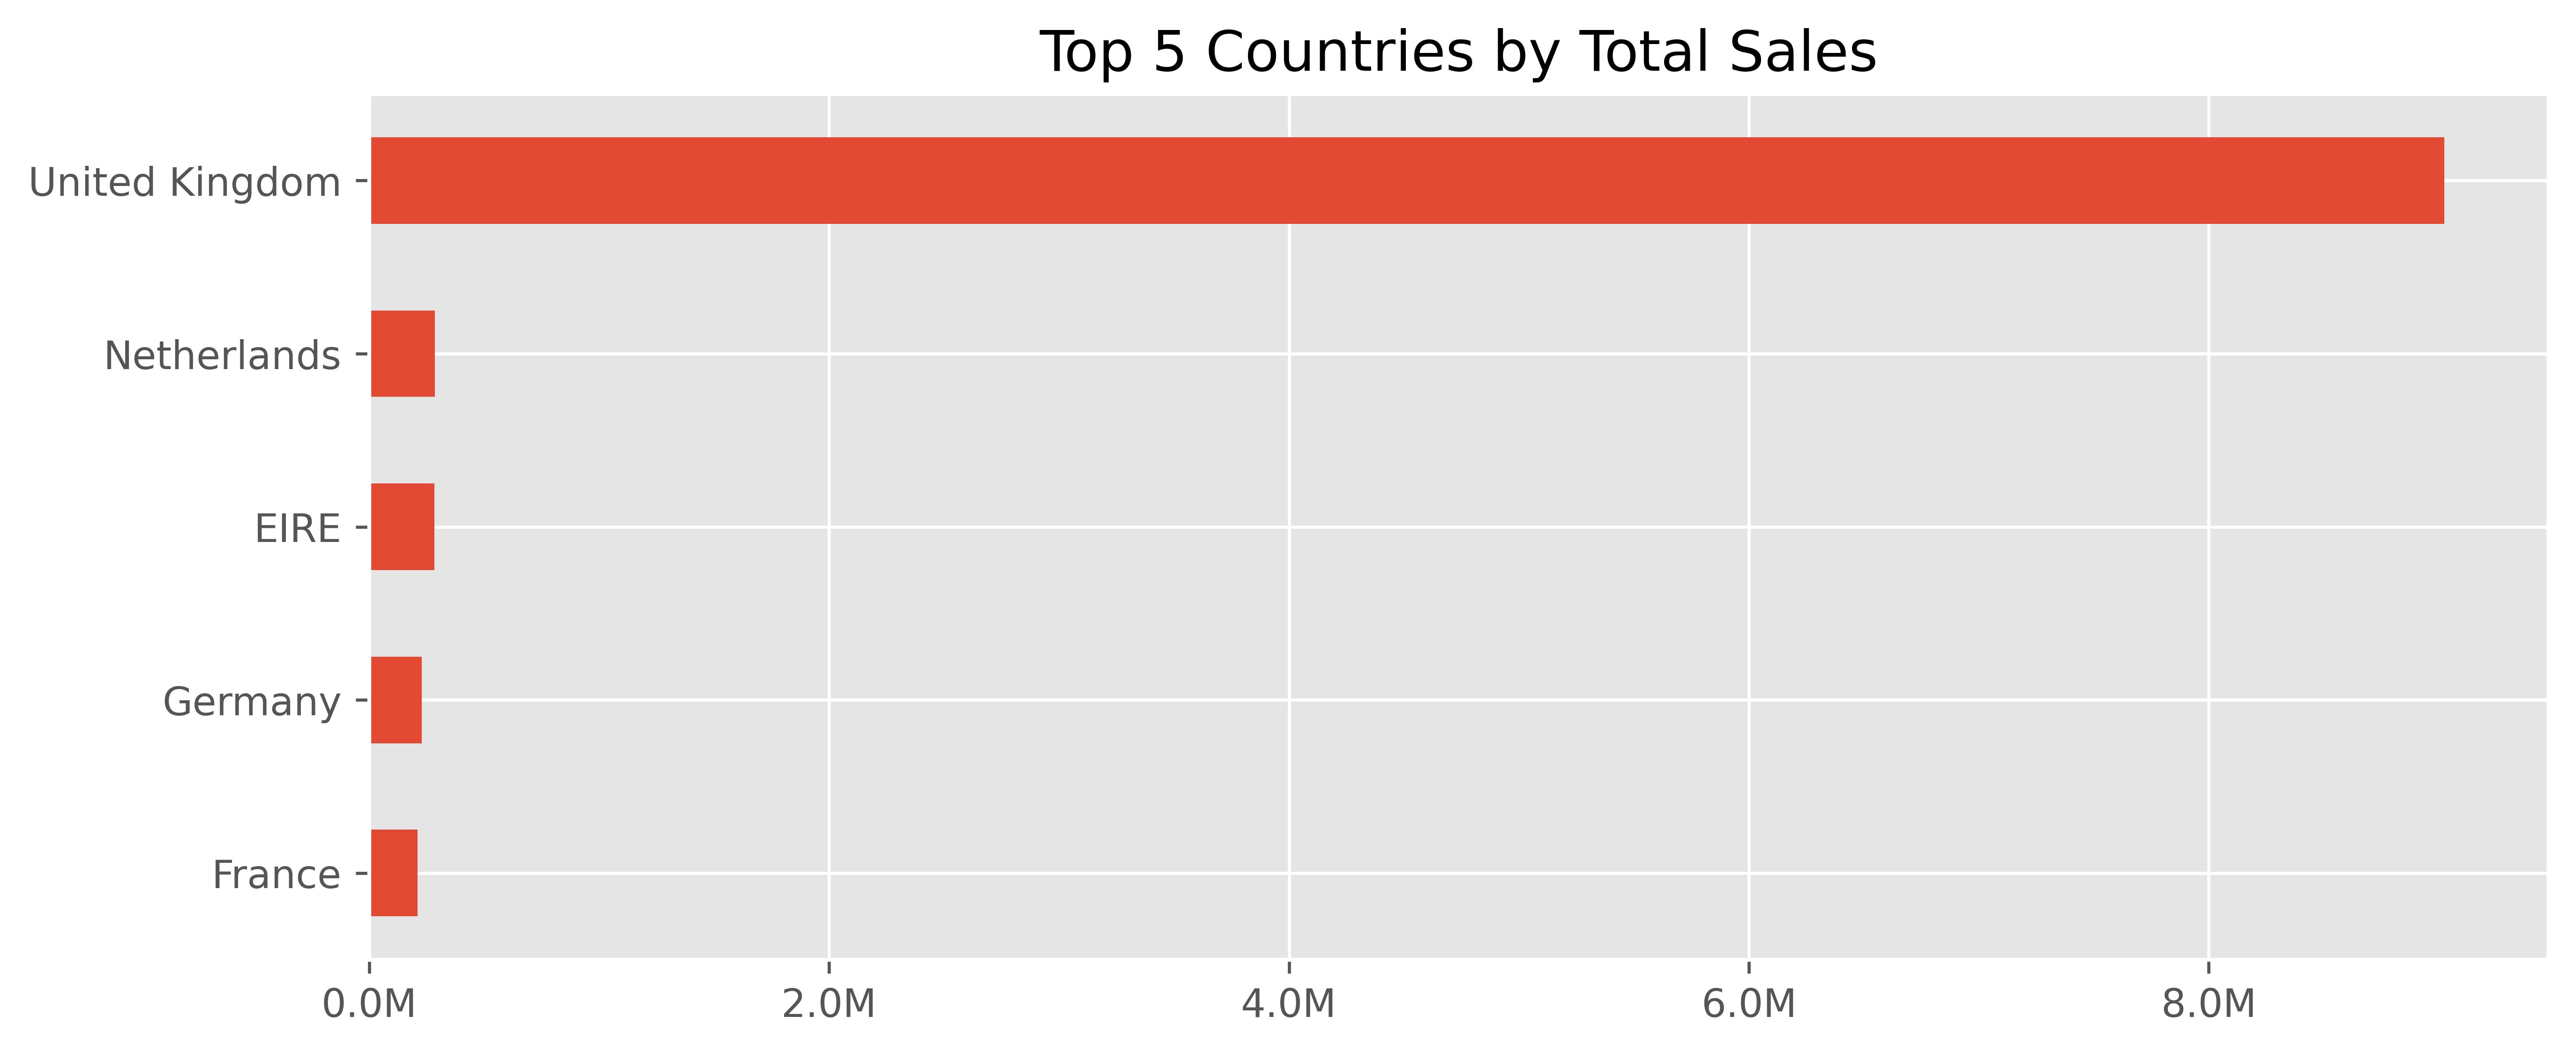

In [25]:
fig, ax = plt.subplots()

(df4.groupby("Country")["TotalSales"]
 .sum()
 .sort_values(ascending=True)
 .tail()
 .plot(ax=ax, kind="barh", title="Top 5 Countries by Total Sales")
)

ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.ylabel('')
plt.xlabel('')
plt.show()

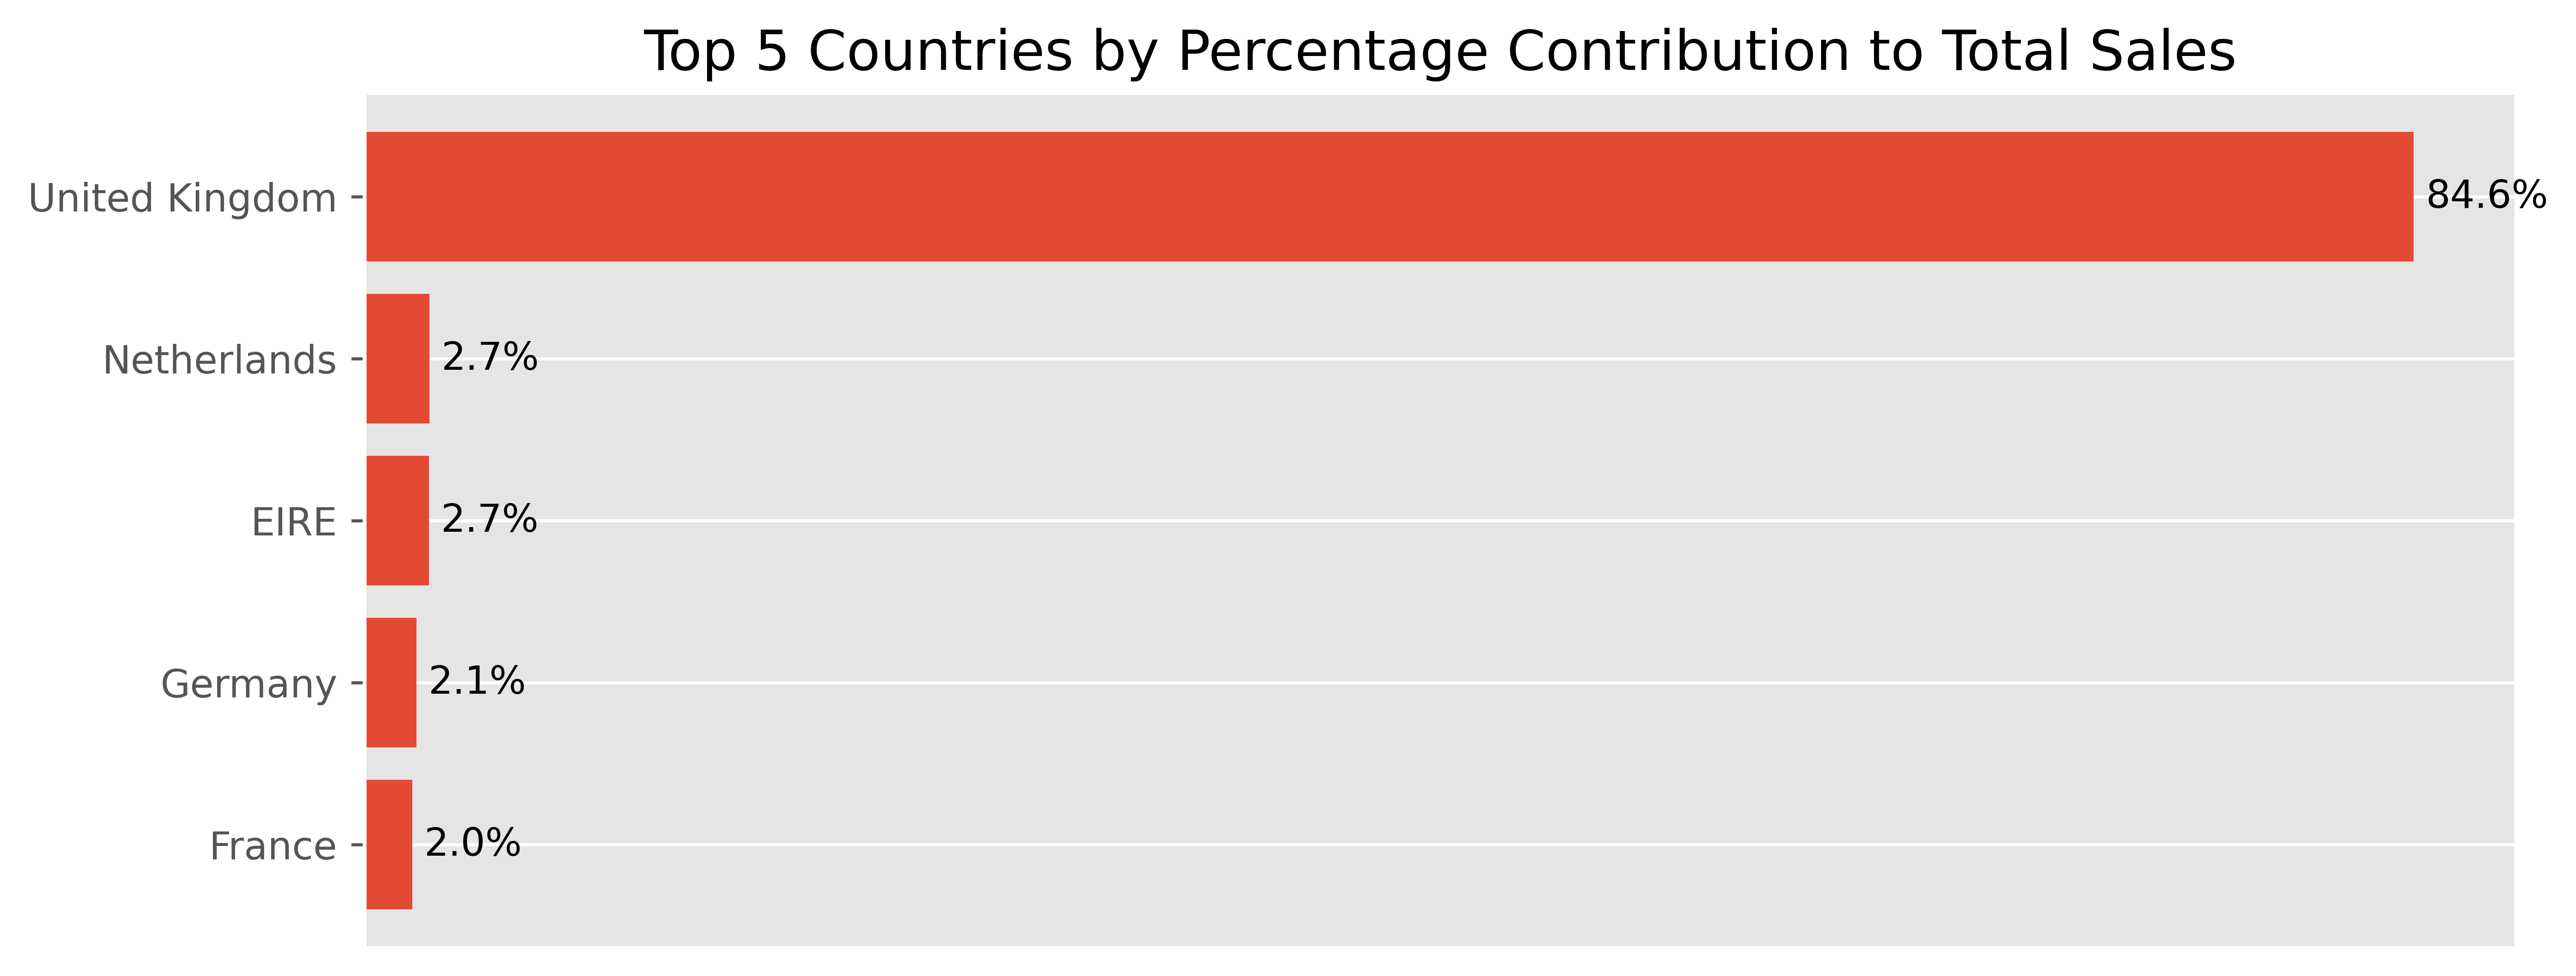

In [26]:
country_wise_sales = df4.groupby('Country')['TotalSales'].sum()
total_sales = country_wise_sales.sum()

top_5_countries = country_wise_sales.sort_values(ascending=False).head(5)
percentages = (top_5_countries / total_sales) * 100

bars = plt.barh(top_5_countries.index, percentages)
plt.xlabel('')
plt.ylabel('')
plt.title('Top 5 Countries by Percentage Contribution to Total Sales')

# Add percentage labels to the bars
for bar, percentage in zip(bars, percentages):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height()/2,
        f'{percentage:.1f}%',
        va='center'
    )

plt.gca().invert_yaxis()
plt.xticks([]) # Hide the X-axis
plt.show()

#### RFM Analysis

In [27]:
current_dt = df4["InvoiceDate"].max() + pd.Timedelta(days=1)
current_dt

Timestamp('2011-12-10 12:50:00')

In [28]:
rfm = df4.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (current_dt - x.max()).days,
    "InvoiceNo": "count",
    "TotalSales": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [29]:
# Segment Customers based on RFM
rfm['R_Segment'] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm['F_Segment'] = pd.qcut(rfm["Frequency"], 4, labels=[1, 2, 3, 4])
rfm['M_Segment'] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = rfm[["R_Segment", "F_Segment", "M_Segment"]].sum(axis=1)
rfm['RFM_Segment'] = rfm['R_Segment'].astype(str) + rfm['F_Segment'].astype(str) + rfm['M_Segment'].astype(str)

def segment_name(score):
    if score >= 10:
        return 'Champions'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalists'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment_Name'] = rfm['RFM_Score'].apply(segment_name)

rfm

,Recency,Frequency,Monetary,R_Segment,F_Segment,M_Segment,RFM_Score,RFM_Segment,Segment_Name
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,114,Potential Loyalists
12347.0,2,182,4310.00,4,4,4,12,444,Champions
12348.0,75,31,1797.24,2,2,4,8,224,Loyal Customers
12349.0,19,73,1757.55,3,3,4,10,334,Champions
12350.0,310,17,334.40,1,1,2,4,112,At Risk
...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,3,111,Lost
18281.0,181,7,80.82,1,1,1,3,111,Lost
18282.0,8,12,178.05,4,1,1,6,411,Potential Loyalists


In [30]:
rfm.describe()

,Recency,Frequency,Monetary,RFM_Score
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.536422,91.720609,2054.266460,7.505071
std,100.014169,228.785094,8989.230441,2.817089
min,1.000000,1.000000,3.750000,3.000000
25%,18.000000,17.000000,307.415000,5.000000
50%,51.000000,41.000000,674.485000,7.000000
75%,142.000000,100.000000,1661.740000,10.000000
max,374.000000,7847.000000,280206.020000,12.000000


In [31]:
rfm[['RFM_Segment', 'RFM_Score', 'Segment_Name']].value_counts(normalize=True).reset_index().head()

,RFM_Segment,RFM_Score,Segment_Name,proportion
0,444,12,Champions,0.103043
1,111,3,Lost,0.088751
2,344,11,Champions,0.050023
3,122,5,Potential Loyalists,0.047487
4,211,4,At Risk,0.041263


##### Heatmap of RFM Scores

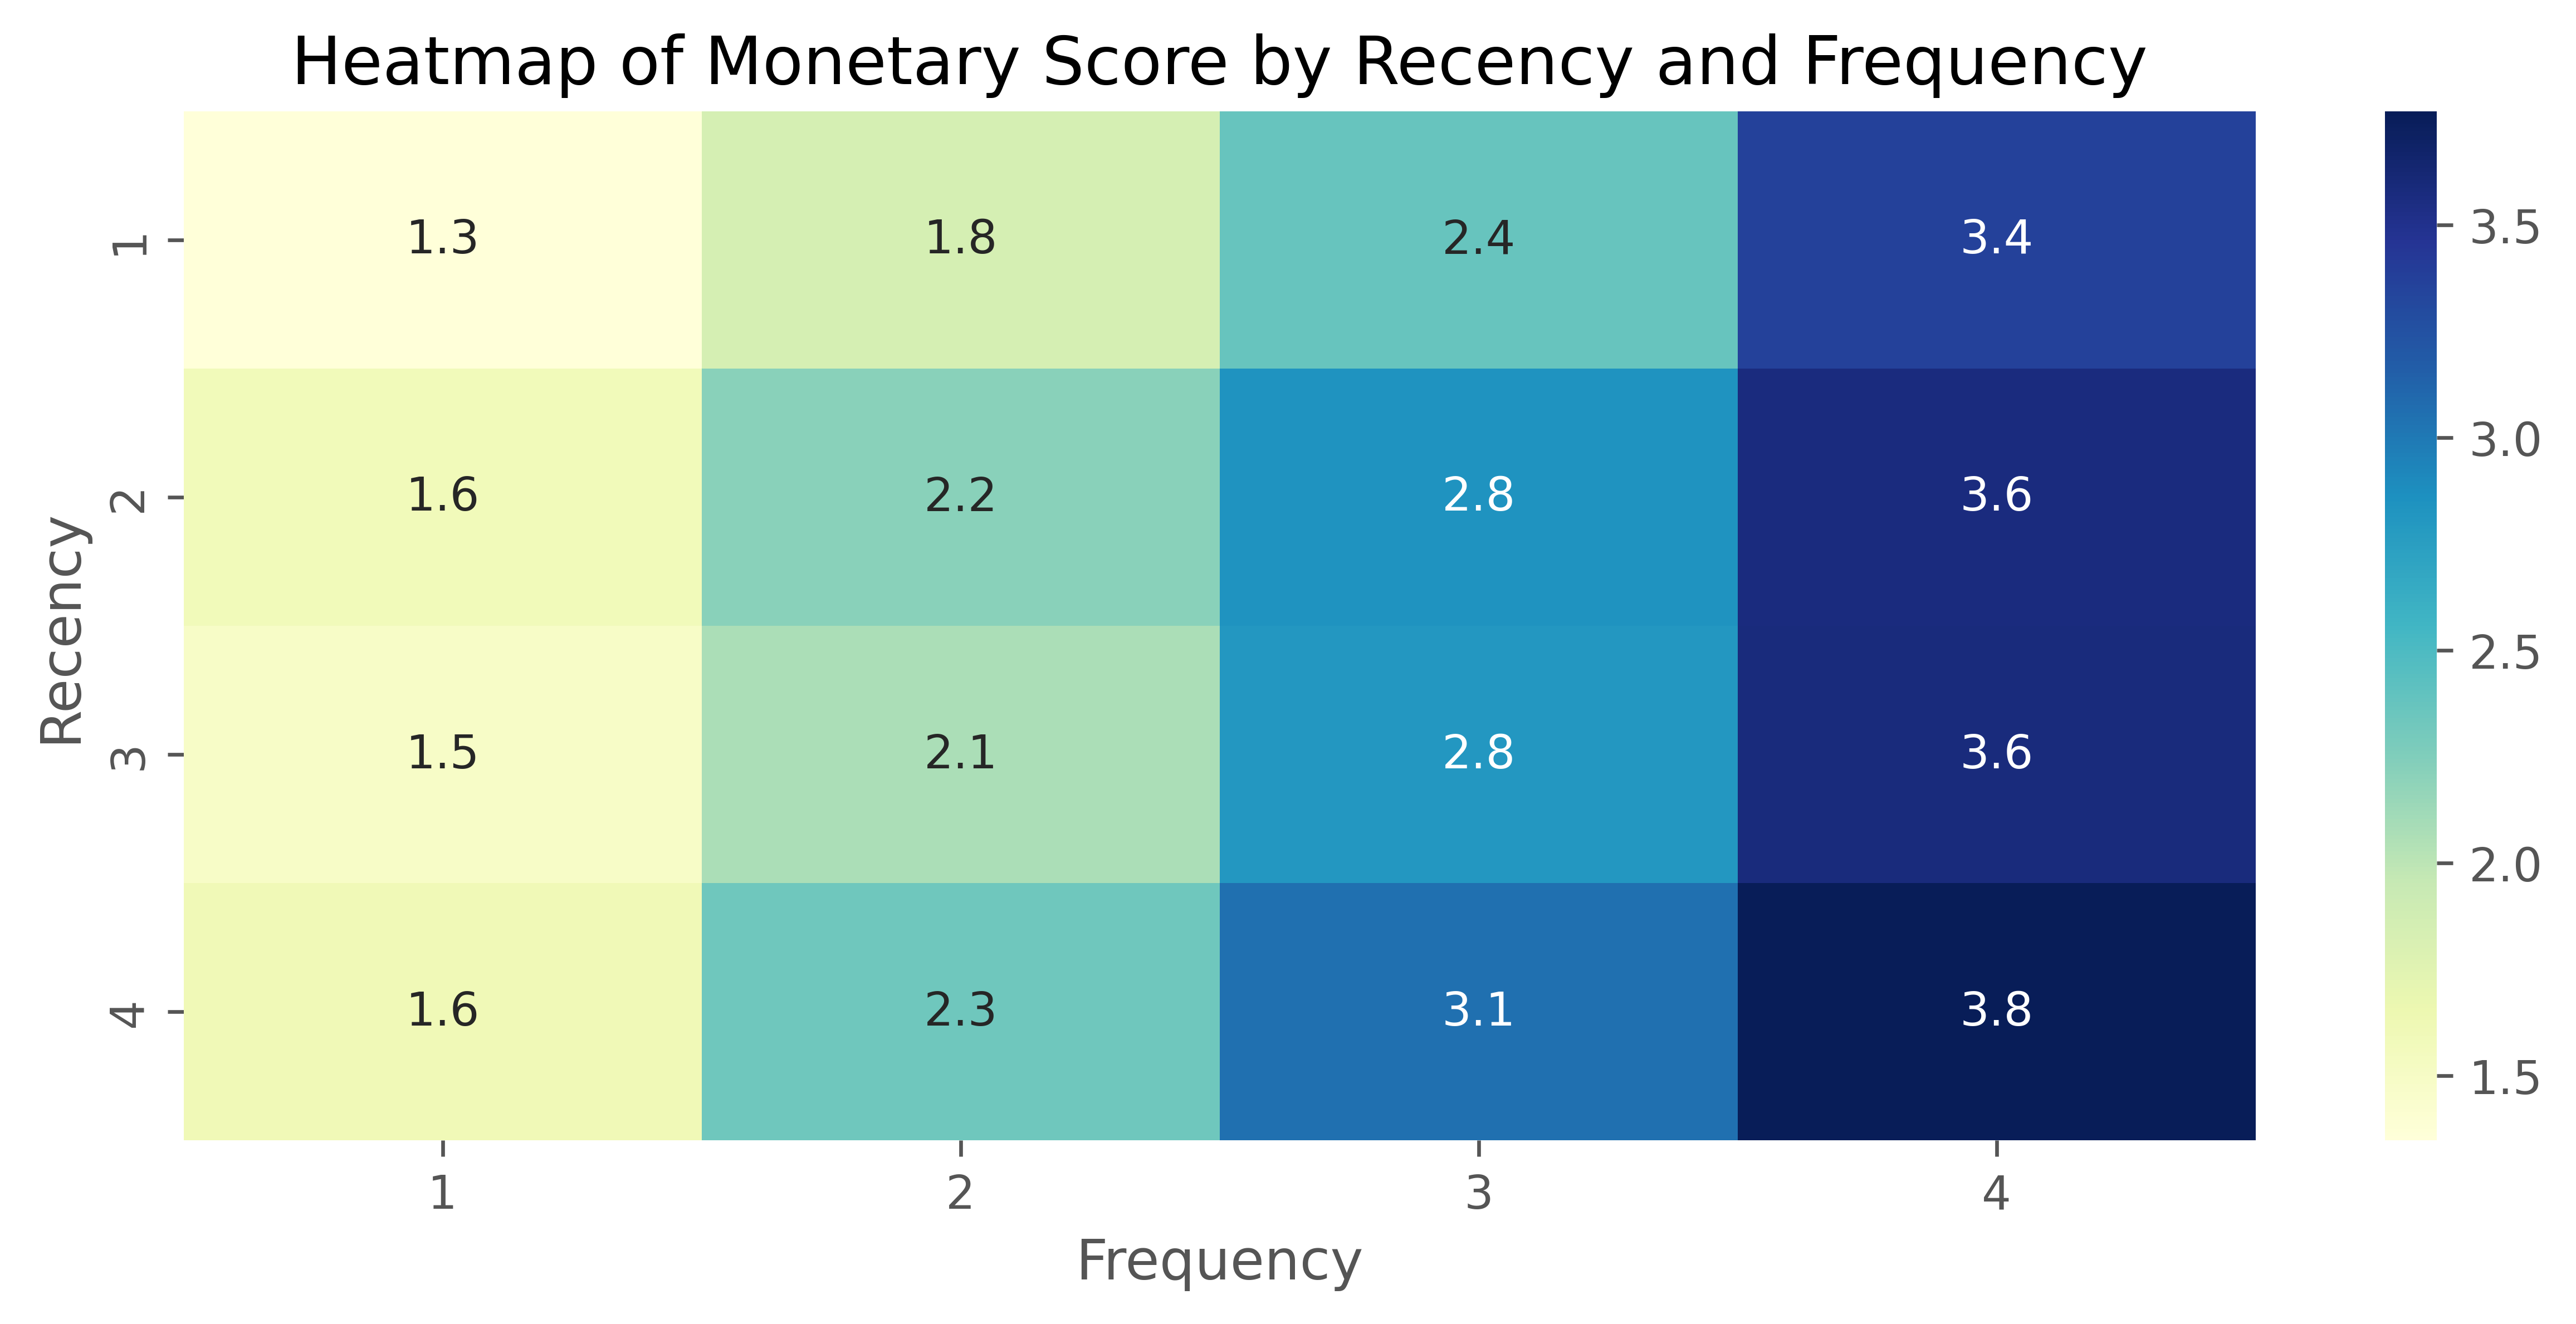

In [32]:
rfm_heatmap = (rfm
 .astype({ 'R_Segment': 'int8', 'F_Segment': 'int8', 'M_Segment': 'int8' })
 .groupby(['R_Segment', 'F_Segment'])['M_Segment']
 .mean()
 .unstack()
)

sns.heatmap(rfm_heatmap, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Heatmap of Monetary Score by Recency and Frequency')
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.show()

##### Further Explorations by Merging RFM + Transactional Data
- Product preferences:      What products are preferred by "Champions" vs "At Risk"?
- Time to churn:    	    How long does it take before high RFM customers drop off?
- Channel/seasonal trends:  Do top segments buy during specific months?
- Profitability heatmaps:   Combine CLTV with RFM for 2D heatmaps
- Re-purchase probability:  When are they most likely to return? (can build survival models)

#### Customer Lifetime Value (CLTV)

##### Simplified Deterministic Model - Average Order Value × Purchase Frequency × Customer Lifespan

In [33]:
customer_sales = df4.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'TotalSales': 'sum',
    'InvoiceDate': ['min', 'max']
})

customer_sales.columns = ['TotalOrders', 'TotalRevenue', 'FirstPurchase', 'LastPurchase']
customer_sales['CustomerLifespan'] = (customer_sales['LastPurchase'] - customer_sales['FirstPurchase']).dt.days

# Fill lifespan=1 if only one purchase
customer_sales['CustomerLifespan'] = customer_sales['CustomerLifespan'].apply(lambda x: x if x > 0 else 1)
# Set minimum lifespan to avoid inflating frequency
customer_sales['AdjustedLifespan'] = customer_sales['CustomerLifespan'].clip(lower=30)

# Calculate Average Order Value
customer_sales['AOV'] = customer_sales['TotalRevenue'] / customer_sales['TotalOrders']

# Purchase Frequency
customer_sales['PurchaseFrequencyPerMonth'] = customer_sales['TotalOrders'] / (customer_sales['AdjustedLifespan'] / 30)

# Estimate CustomerLifetimeInMonths as an average lifespan across all customers, or set a fixed horizon (e.g. 6 or 12 months)
CustomerLifetimeInMonths = 3
customer_sales['CLTV'] = (customer_sales['AOV'] * customer_sales['PurchaseFrequencyPerMonth'] * CustomerLifetimeInMonths).astype('int')

customer_sales.head()

,TotalOrders,TotalRevenue,FirstPurchase,LastPurchase,CustomerLifespan,AdjustedLifespan,AOV,PurchaseFrequencyPerMonth,CLTV
CustomerID,,,,,,,,,
12346.0,1,77183.60,2011-01-18 10:01:00,2011-01-18 10:01:00,1,30,77183.600000,1.000000,231550
12347.0,7,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00,365,365,615.714286,0.575342,1062
12348.0,4,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00,282,282,449.310000,0.425532,573
12349.0,1,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00,1,30,1757.550000,1.000000,5272
12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,1,30,334.400000,1.000000,1003


In [34]:
customer_sales = df4.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'TotalSales': 'sum',
    'InvoiceDate': ['min', 'max']
})

customer_sales.columns = ['TotalOrders', 'TotalRevenue', 'FirstPurchase', 'LastPurchase']
customer_sales['CustomerLifespan'] = (customer_sales['LastPurchase'] - customer_sales['FirstPurchase']).dt.days

# Fill lifespan=1 if only one purchase
customer_sales['CustomerLifespan'] = customer_sales['CustomerLifespan'].apply(lambda x: x if x > 0 else 1)

# Calculate Average Order Value
customer_sales['AOV'] = customer_sales['TotalRevenue'] / customer_sales['TotalOrders']

# Purchase Frequency
customer_sales['PurchaseFrequencyPerMonth'] = np.where(
    customer_sales['TotalOrders'] > 1,
    customer_sales['TotalOrders'] / (customer_sales['CustomerLifespan'] / 30),
    1 / 3  # Assume a conservative baseline (e.g., 1 order per 3 months)
)

# Estimate CustomerLifetimeInMonths as an average lifespan across all customers, or set a fixed horizon (e.g. 6 or 12 months)
CustomerLifetimeInMonths = 3
customer_sales['CLTV'] = (customer_sales['AOV'] * customer_sales['PurchaseFrequencyPerMonth'] * CustomerLifetimeInMonths).astype('int')

customer_sales.head()

,TotalOrders,TotalRevenue,FirstPurchase,LastPurchase,CustomerLifespan,AOV,PurchaseFrequencyPerMonth,CLTV
CustomerID,,,,,,,,
12346.0,1,77183.60,2011-01-18 10:01:00,2011-01-18 10:01:00,1,77183.600000,0.333333,77183
12347.0,7,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00,365,615.714286,0.575342,1062
12348.0,4,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00,282,449.310000,0.425532,573
12349.0,1,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00,1,1757.550000,0.333333,1757
12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,1,334.400000,0.333333,334


##### Probabilistic CLTV

In [35]:
# Step 1: Prepare the Transactional Dataset
from lifetimes.utils import summary_data_from_transaction_data

cltv_data = summary_data_from_transaction_data(
    df4,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalSales',
    observation_period_end=df4['InvoiceDate'].max()
)

cltv_data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [36]:
# Step 2: Fit the BG/NBD Model (Purchase Frequency)
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(cltv_data['frequency'], cltv_data['recency'], cltv_data['T'])

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 49.42, b: 0.00, r: 0.59>

In [37]:
# Predict expected purchases in the next n days:
cltv_data['predicted_purchases_6m'] = bgf.predict(
    180, 
    cltv_data['frequency'], 
    cltv_data['recency'], 
    cltv_data['T']
)

c:\Users\NGU CHU SENG\anaconda3\envs\analysis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
# Step 3: Fit the Gamma-Gamma Model (Monetary Value)
from lifetimes import GammaGammaFitter

# Filter customers with monetary > 0 and frequency > 0
cltv_data = cltv_data[cltv_data['monetary_value'] > 0]
cltv_data = cltv_data[cltv_data['frequency'] > 0]

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_data['frequency'], cltv_data['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 3.75, q: 0.33, v: 3.64>

In [39]:
# Predict average expected order value
cltv_data['expected_average_value'] = ggf.conditional_expected_average_profit(
    cltv_data['frequency'], cltv_data['monetary_value']
)

In [40]:
# Step 4: Estimate Probabilistic CLTV
cltv_data['cltv_6m'] = ggf.customer_lifetime_value(
    bgf, 
    cltv_data['frequency'],
    cltv_data['recency'],
    cltv_data['T'],
    cltv_data['monetary_value'],
    time=6,         # months
    freq='D',       # frequency of your data: 'D' = daily
    discount_rate=0.01  # optional: apply discounting
)

In [41]:
cltv_data

,frequency,recency,T,monetary_value,predicted_purchases_6m,expected_average_value,cltv_6m
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,2.850112,618.580281,1702.926539
12348.0,3.0,283.0,358.0,301.480000,1.587667,321.698923,493.340767
12352.0,6.0,260.0,296.0,368.256667,3.435939,380.090885,1261.452102
12356.0,2.0,303.0,325.0,269.905000,1.246858,298.146326,359.074207
12358.0,1.0,149.0,150.0,683.200000,1.438411,834.789440,1159.839068
...,...,...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,3.408172,506.431204,1667.169680
18273.0,2.0,255.0,257.0,76.500000,1.523555,85.936874,126.466492
18282.0,1.0,119.0,126.0,77.840000,1.635203,99.035083,156.422269


In [42]:
# Step 5: Merge with RFM / Segment
rfm_cltv = rfm.merge(cltv_data[['cltv_6m']], left_index=True, right_index=True, how='left')
rfm_cltv

,Recency,Frequency,Monetary,R_Segment,F_Segment,M_Segment,RFM_Score,RFM_Segment,Segment_Name,cltv_6m
CustomerID,,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,114,Potential Loyalists,NaN
12347.0,2,182,4310.00,4,4,4,12,444,Champions,1702.926539
12348.0,75,31,1797.24,2,2,4,8,224,Loyal Customers,493.340767
12349.0,19,73,1757.55,3,3,4,10,334,Champions,NaN
12350.0,310,17,334.40,1,1,2,4,112,At Risk,NaN
...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,3,111,Lost,NaN
18281.0,181,7,80.82,1,1,1,3,111,Lost,NaN
18282.0,8,12,178.05,4,1,1,6,411,Potential Loyalists,156.422269


<Axes: ylabel='Segment_Name'>

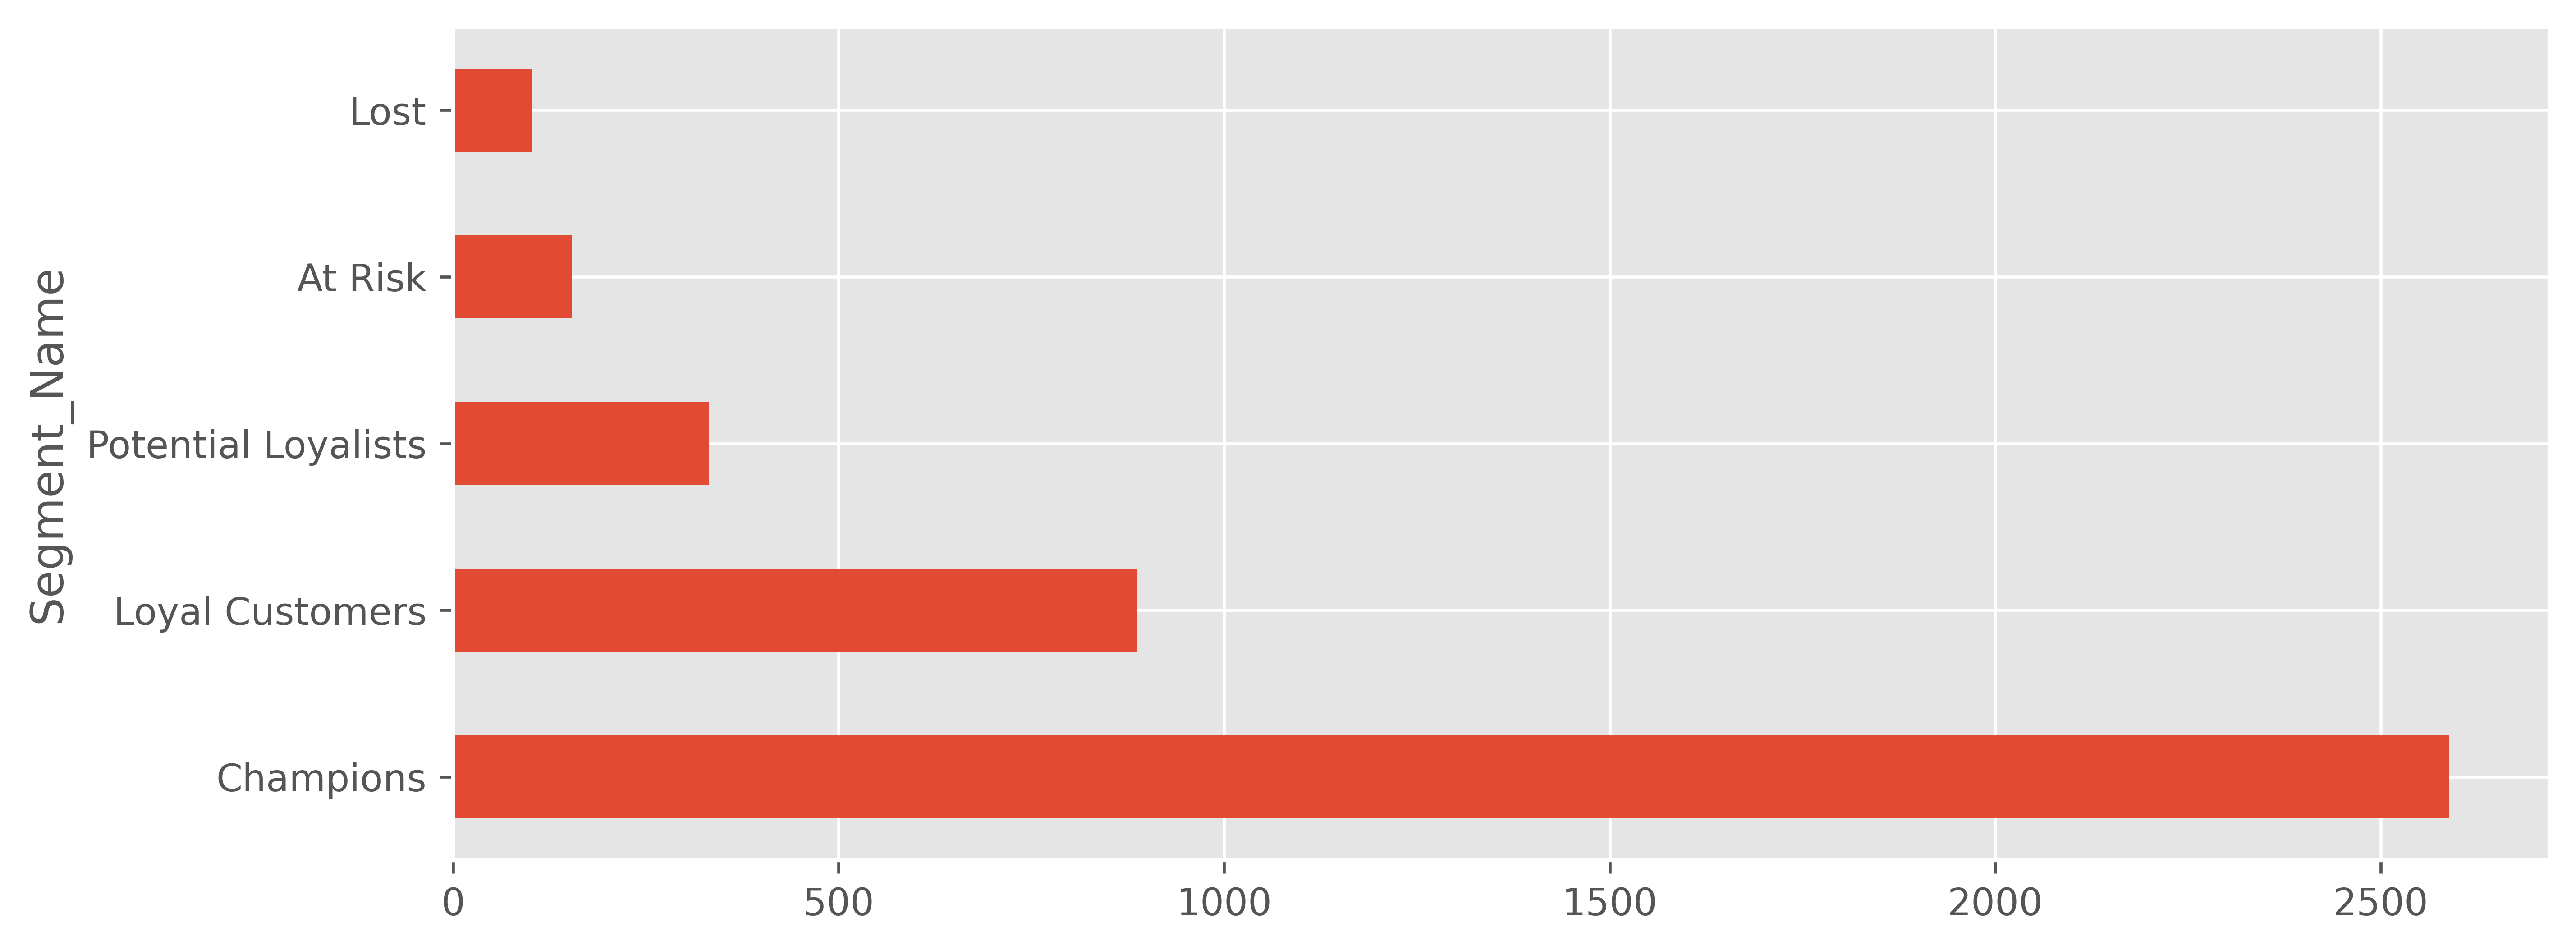

In [43]:
rfm_cltv.groupby('Segment_Name')['cltv_6m'].mean().sort_values(ascending=False).plot(kind='barh')

#### Customer Churn Analysis

In [44]:
current_dt

Timestamp('2011-12-10 12:50:00')

In [45]:
# Create a basket matrix for association rule mining
customer_last_purchase = df4.groupby("CustomerID")["InvoiceDate"].max()
customer_last_purchase.head(5)

CustomerID
12346.0   2011-01-18 10:01:00
12347.0   2011-12-07 15:52:00
12348.0   2011-09-25 13:13:00
12349.0   2011-11-21 09:51:00
12350.0   2011-02-02 16:01:00
Name: InvoiceDate, dtype: datetime64[ns]

In [46]:
customer_last_purchase = (customer_last_purchase
 .reset_index()
 .set_index("CustomerID")
 .rename(columns={"InvoiceDate": "LastPurchaseDate"})
 .assign(RecencyDays=lambda df_: (current_dt - df_.LastPurchaseDate).dt.days)
)

customer_last_purchase.head(5)

,LastPurchaseDate,RecencyDays
CustomerID,,
12346.0,2011-01-18 10:01:00,326
12347.0,2011-12-07 15:52:00,2
12348.0,2011-09-25 13:13:00,75
12349.0,2011-11-21 09:51:00,19
12350.0,2011-02-02 16:01:00,310


In [47]:
# Define churn threshold
churn_threshold = 90
churned_customers = customer_last_purchase[customer_last_purchase["RecencyDays"] > churn_threshold]
churned_customers.head()

,LastPurchaseDate,RecencyDays
CustomerID,,
12346.0,2011-01-18 10:01:00,326
12350.0,2011-02-02 16:01:00,310
12353.0,2011-05-19 17:47:00,204
12354.0,2011-04-21 13:11:00,232
12355.0,2011-05-09 13:49:00,214


Number of Churned Customers:  1449


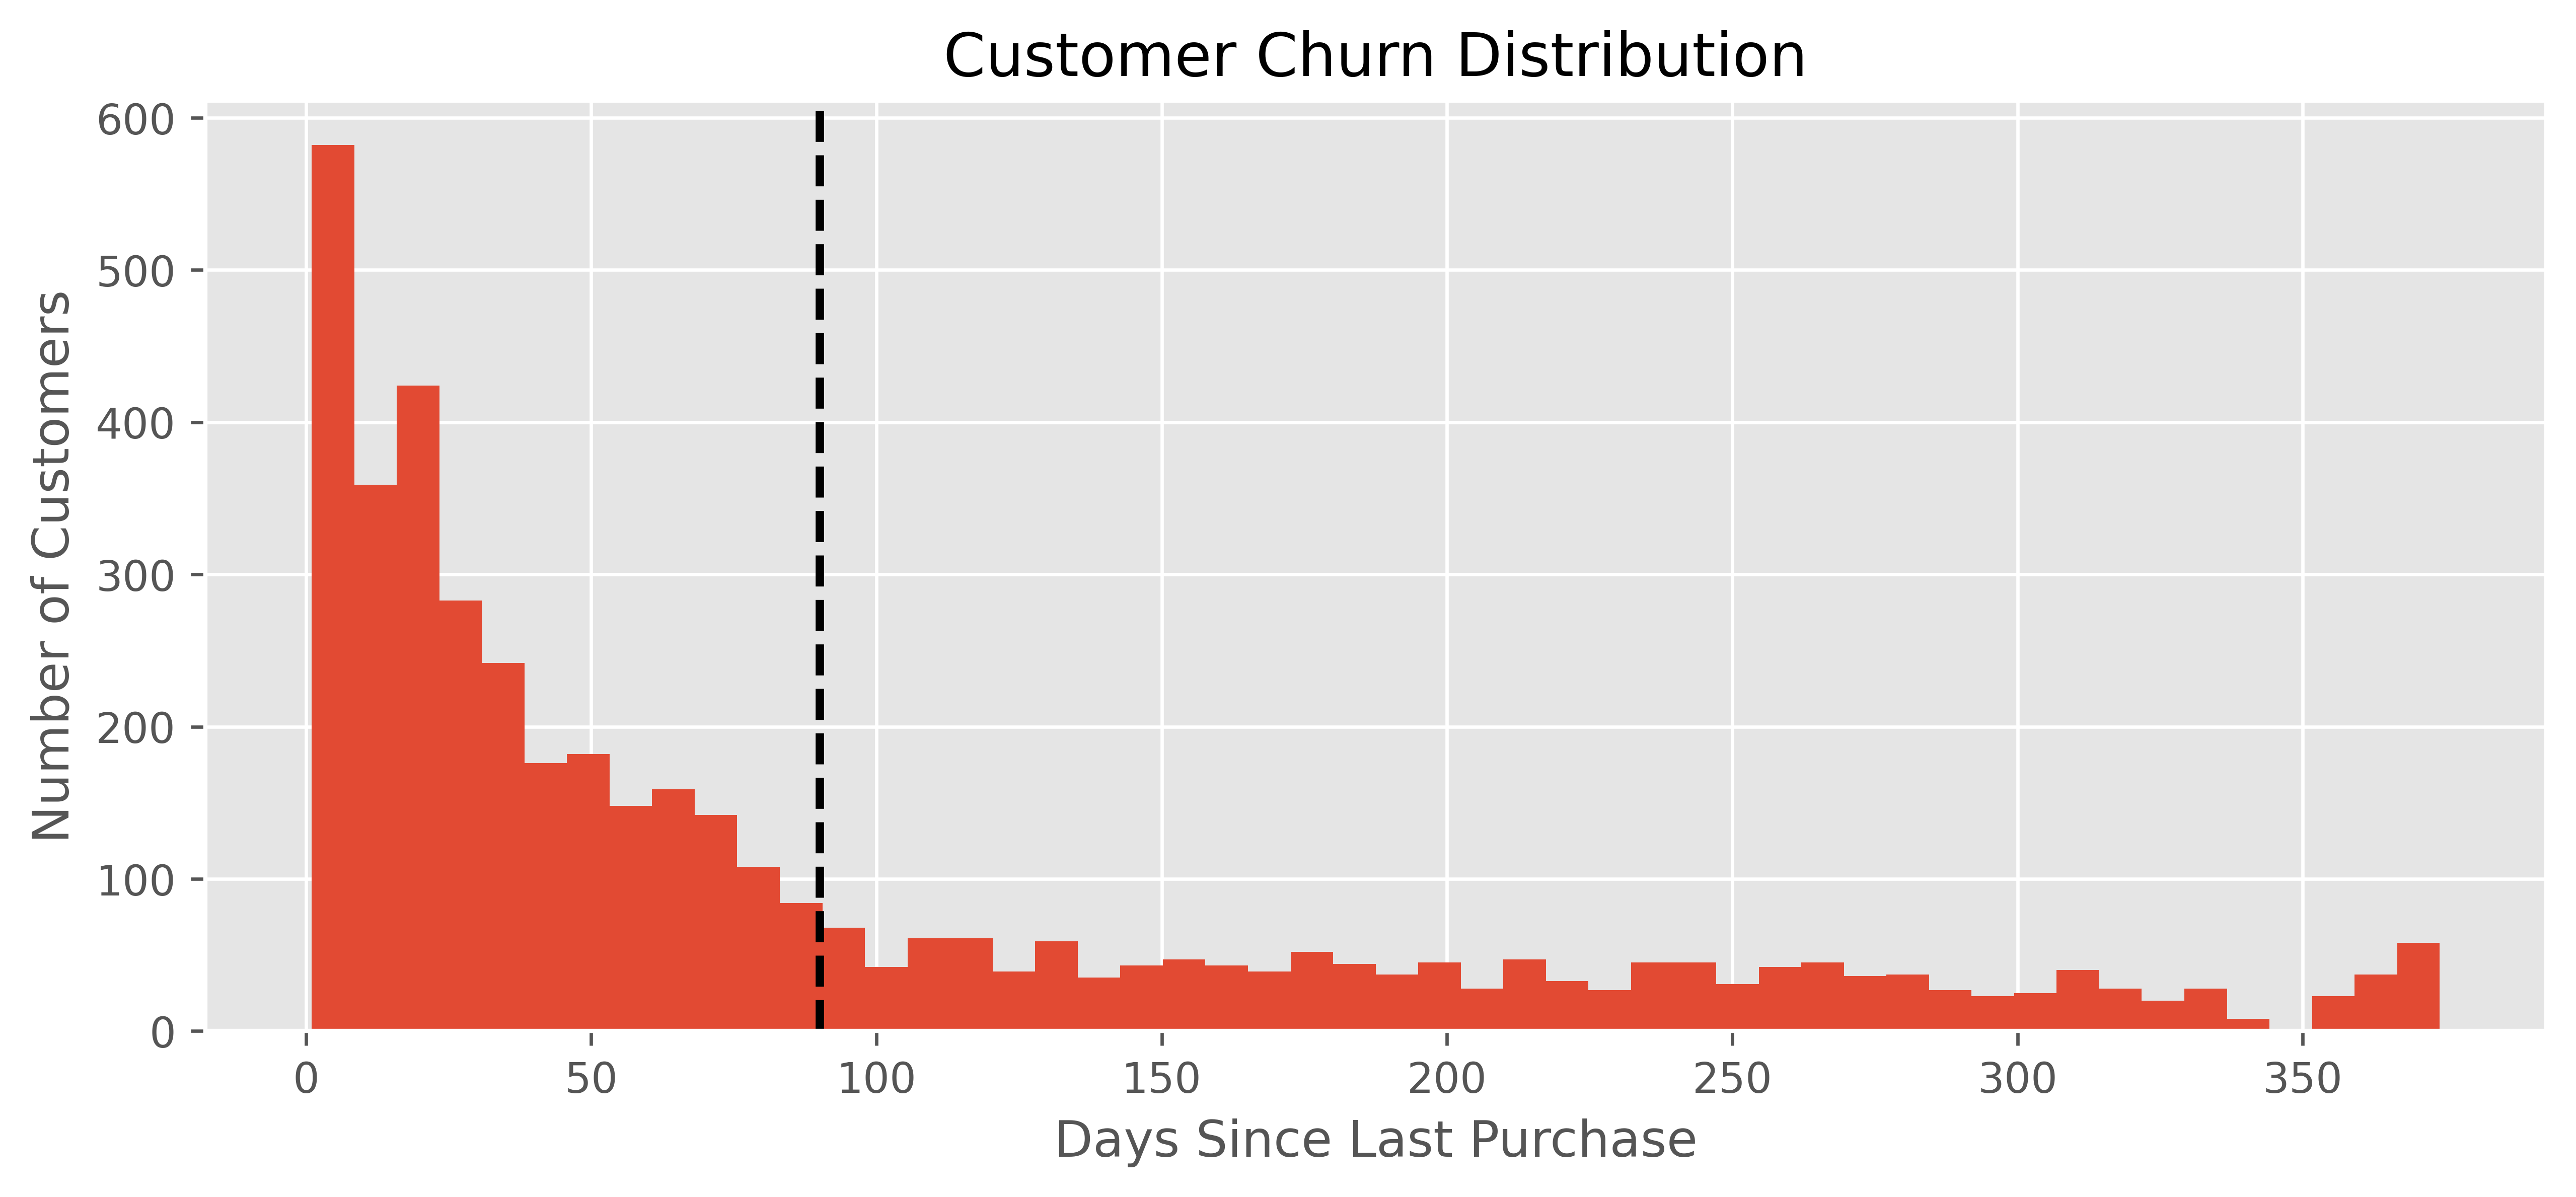

In [48]:
print("Number of Churned Customers: ", len(churned_customers))
plt.hist(customer_last_purchase["RecencyDays"], bins=50)
plt.axvline(churn_threshold, color="black", linestyle="dashed", linewidth=2)
plt.title("Customer Churn Distribution")
plt.xlabel("Days Since Last Purchase")
plt.ylabel("Number of Customers")
plt.show()

#### Runtime

In [49]:
print(f"[{pd.__name__}] total time taken: {time.time() - stime} sec")

[pandas] total time taken: 49.52251958847046 sec
